# Filtrage collaboratif avec Implicit
On va utiliser la version qui travaille avec le GPU

In [1]:
! nvidia-smi

Tue Apr 22 20:52:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P8              5W /   80W |      94MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Données

### Chargement du dataframe global

In [2]:
import pandas as pd

df = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [3]:
df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


### Liste des articles

In [3]:
df_articles = pd.read_csv("./data/articles_with_popularity.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count,cluster,publish_time_dt,nb_clics,popularite_tag,popularity_norm
0,0,0,1513144419000,0,168,16,2017-12-13 05:53:39,0,jamais_cliqué,0.000000
1,1,1,1405341936000,0,189,11,2014-07-14 12:45:36,0,jamais_cliqué,0.000000
2,2,1,1408667706000,0,250,3,2014-08-22 00:35:06,0,jamais_cliqué,0.000000
3,3,1,1408468313000,0,230,3,2014-08-19 17:11:53,1,banal,0.000027
4,4,1,1407071171000,0,162,3,2014-08-03 13:06:11,0,jamais_cliqué,0.000000
...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,0,144,2,2015-06-11 14:48:38,0,jamais_cliqué,0.000000
364043,364043,460,1434148472000,0,463,7,2015-06-12 22:34:32,8,banal,0.000215
364044,364044,460,1457974279000,0,177,6,2016-03-14 16:51:19,0,jamais_cliqué,0.000000
364045,364045,460,1515964737000,0,126,1,2018-01-14 21:18:57,0,jamais_cliqué,0.000000


### Chargement des embeddings réduits

In [4]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [5]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,0.426074,0.545480,-0.807394,1.520171,...,0.387738,-0.088799,0.990514,1.060148,-0.218378,-1.099852,-1.175524,1.370632,-0.264816,0.010117
1,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,2.389835,-1.267244,1.944162,2.980629,...,0.025565,-0.721510,0.649929,-0.405225,-0.090690,-3.094968,0.075186,0.245235,-1.250343,0.294538
2,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,-1.815688,-2.170389,-2.783090,2.804910,...,0.565647,-1.862223,-0.336458,0.072410,0.241466,-0.877634,0.154883,1.133963,0.946740,-1.811314
3,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,1.070822,-2.160001,1.947324,4.069597,...,0.074049,-0.612824,-1.511408,1.071736,1.991838,-2.076190,-1.690459,-1.122692,0.714619,-1.576244
4,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,0.308953,0.310888,-1.054171,2.158180,...,-1.527867,-0.155615,-0.163345,0.037253,1.173636,-4.232923,-1.287476,1.053438,-0.486085,-0.144550


In [6]:
# conversion des embeddings en tableau NumPy (évite de calculer la matrice de similarité complète)
import numpy as np
article_ids = embeddings_df.index.to_numpy()
article_embeddings = embeddings_df.to_numpy()

# dictionnaire article_id -> vecteur
embedding_dict = dict(zip(article_ids, article_embeddings))

## Préparation des données pour Implicit

### Création de la matrice item-user
On a simplement ignoré les articles non cliqués.

In [8]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np

def build_item_user_matrix(df_clicks):
    """
    Construit une matrice sparse (CSR) article × utilisateur pour implicit ALS,
    avec pondération linéaire des clics, remapping auto et barre de progression.

    Retourne :
    - item_user_matrix : matrice CSR [n_items_cliqués x n_users_actifs]
    - user_mapping : dict user_id → user_idx
    - item_mapping : dict click_article_id → item_idx
    """

    # Agrégation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Vérification remapping
    u_ids = df_user_item['user_id'].values
    need_remap_users = not (
        u_ids.dtype.kind in 'iu' and u_ids.min() == 0 and len(np.unique(u_ids)) == u_ids.max() + 1
    )

    i_ids = df_user_item['click_article_id'].values
    need_remap_items = not (
        i_ids.dtype.kind in 'iu' and i_ids.min() == 0 and len(np.unique(i_ids)) == i_ids.max() + 1
    )

    if not need_remap_users and not need_remap_items:
        print("✅ Remapping non nécessaire : user_id et click_article_id déjà indexés proprement.")
    else:
        print("🔁 Remapping nécessaire : conversion des IDs en indices entiers contigus.")

    # Création des mappings avec tqdm
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    print("📐 Construction de la matrice sparse...")
    item_user_matrix = coo_matrix(
        (df_user_item['click_strength'],
         (df_user_item['item_idx'], df_user_item['user_idx']))
    ).tocsr()

    print("✅ Matrice prête :", item_user_matrix.shape)
    return item_user_matrix, user_mapping, item_mapping


In [13]:
item_user_matrix, user_mapping, item_mapping = build_item_user_matrix(df)


🔁 Remapping nécessaire : conversion des IDs en indices entiers contigus.
🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 46033/46033 [00:00<00:00, 3631439.89it/s]


📐 Construction de la matrice sparse...
✅ Matrice prête : (46033, 322897)


### Visualisation de la matrice item-user

In [14]:
import matplotlib.pyplot as plt

def plot_sparse_matrix_density(sparse_matrix, title="Matrice sparse (articles × utilisateurs)"):
    plt.figure(figsize=(10, 6))
    plt.spy(sparse_matrix, markersize=0.5)
    plt.title(title)
    plt.xlabel("Utilisateurs")
    plt.ylabel("Articles")
    plt.grid(True)
    plt.show()


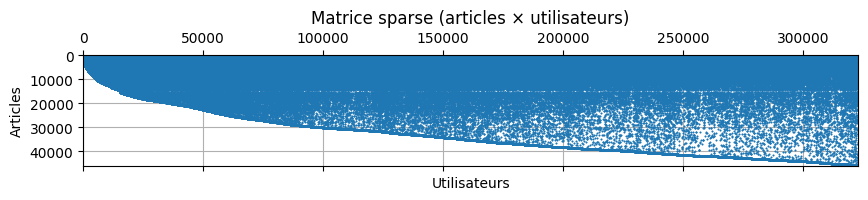

In [15]:
plot_sparse_matrix_density(item_user_matrix)

In [16]:
def print_matrix_density(sparse_matrix):
    n_total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    n_nonzero = sparse_matrix.nnz
    density = n_nonzero / n_total * 100

    print(f"📦 Taux de remplissage : {n_nonzero:,} éléments non nuls")
    print(f"📐 Dimensions         : {sparse_matrix.shape}")
    print(f"📊 Densité            : {density:.6f}%")

In [17]:
print_matrix_density(item_user_matrix)

📦 Taux de remplissage : 2,950,710 éléments non nuls
📐 Dimensions         : (46033, 322897)
📊 Densité            : 0.019851%


## Mise en oeuvre du modèle ALS (Alternative Least Squares)

In [19]:
import time
from implicit.gpu.als import AlternatingLeastSquares

# Paramètres
factors = 64
iterations = 15
regularization = 0.1

# Modèle ALS GPU (pas besoin de use_gpu ici)
model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations
)

# Entraînement
print("⏱️ Entraînement ALS en cours...")
start = time.time()
model.fit(item_user_matrix)
end = time.time()
print(f"✅ Modèle entraîné en {end - start:.2f} secondes")


⏱️ Entraînement ALS en cours...


100%|██████████| 15/15 [00:01<00:00, 10.96it/s]

✅ Modèle entraîné en 1.54 secondes
